# `HF_classification . cointegrated . rubert-tiny` notebook
### Descriprion
This notebook is one of those which were used to training large DL models from `transformers` library and measuring classification performance. However, the tiny model **rubert-tiny** was trained and did not show acceptable results.  

In [3]:
%cd ../..

/home/pristalovya/Документы/nlp-coursework


In [4]:
from datasets_ import DatasetLoader

from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
%matplotlib notebook

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import AdamW

from tqdm import tqdm
import numpy as np

import sys

from nltk import WhitespaceTokenizer

from transformers import (                 
    AutoModelForSequenceClassification,                       
    BertForSequenceClassification,                       
    AutoTokenizer,
    AdamW,
)

In [5]:
train, test = DatasetLoader.load_reviews_Review_Label_dataset(train_test_split=True,
                                                              classnames_to_int=True,
                                                              remove_neutral_class=True,
                                                              show_path=True,)
train.label[train['label'] == 2] = 1
test.label[test['label'] == 2] = 1

print(train.shape, test.shape)

/home/pristalovya/Документы/nlp-coursework/data/reviews_Review_Label/reviews_Review_Label.csv
(55346, 2) (23721, 2)


/tmp/ipykernel_7159/3832119039.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.label[train['label'] == 2] = 1
/tmp/ipykernel_7159/3832119039.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.label[test['label'] == 2] = 1


In [6]:
test

,review,label
25749,Большое количество фильмов советского кинемато...,1
44489,"Тяжело ответить на вопрос, что же такое Догвил...",1
53162,"В наше время такие героини, как скажем наприме...",0
25843,В 2001 году нам довелось познакомиться с новой...,1
44609,"«Это фильм?», «У них не хватило денег на декор...",1
...,...,...
14104,- Через столько лет?\r\n- Всегда\r\n\r\nБезусл...,1
22232,"После просмотра трейлера, я был под большим вп...",1
73314,"Многие не верят, но я легко подключаюсь к прои...",1
47848,"Как часто нам нужна поддержка? Да, пожалуй, оч...",1


In [5]:
text = test.review.iloc[0]
text[:100]

'Большое количество фильмов советского кинематографа посвящено второй мировой войне. В них поднимаютс'

In [7]:
# ~48 MB

checkpoint = 'cointegrated/rubert-tiny'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

In [8]:
class ReviewDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_model_input_length=512):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_model_input_length = max_model_input_length
        
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, idx):
        review = self.reviews.iloc[idx]
        label = self.labels.iloc[idx]
        review_tokenized = self.tokenizer(
            review,
            add_special_tokens=True,
            max_length=self.max_model_input_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True,
        )
        input_ids = review_tokenized['input_ids'].flatten()
        attn_mask = review_tokenized['attention_mask'].flatten()
        
        return {
            'review': review,
            'input_ids': input_ids,
            'attention_mask': attn_mask,
            'label': label,
        }
        

In [75]:
train_dataset = ReviewDataset(train.review, train.label, tokenizer)
test_dataset = ReviewDataset(test.review, test.label, tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [80]:
model.classifier

Linear(in_features=312, out_features=2, bias=True)

In [44]:
class BertClassifier:
    def __init__(self, checkpoint, n_classes=2):
        self.model = BertForSequenceClassification.from_pretrained(checkpoint)
        self.tokenizer = AutoTokenizer.from_pretrained(checkpoint)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.max_len = 512
        self.out_features = 312
        self.model.classifier = torch.nn.Linear(self.out_features, n_classes)
        self.model.to(self.device)
        self.loss_fn = nn.CrossEntropyLoss()
        
        self.optimizer = torch.optim.Adam(self.model.classifier.parameters(), lr=1e-3)
        
        self.all_losses = []
        self.epoch_losses = []
        self.epoch_acc = []
        

    def fit(self):
        self.model.train()
        losses = []
        correct_predictions = 0

        for data in tqdm(train_dataloader, file=sys.stdout, ncols=100):
            # clear_output()
            input_ids = data['input_ids'].to(self.device)
            attention_mask = data['attention_mask'].to(self.device).to(float)
            labels = data['label'].to(self.device)

            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask
                )

            preds = outputs.logits.argmax(dim=1)
            
            loss = self.loss_fn(outputs.logits, labels)
        
            correct_predictions += torch.sum(preds == labels)

            losses.append(loss.item())

            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()


        train_acc = correct_predictions.double() / len(train_dataset)
        train_loss = np.mean(losses)
        self.all_losses.extend(losses)
        self.epoch_losses.append(train_loss)
        self.epoch_acc.append(train_acc)
        return train_acc, train_loss
    
    
    def evaluate(self):
        self.model.eval()
        losses = []
        correct_predictions = 0
        
        all_preds = []

        with torch.no_grad():
            for data in tqdm(test_dataloader, file=sys.stdout, ncols=100):
                input_ids = data["input_ids"].to(self.device)
                attention_mask = data["attention_mask"].to(self.device)
                labels = data["label"].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )

                preds = torch.argmax(outputs.logits, dim=1)
                loss = self.loss_fn(outputs.logits, labels)
                correct_predictions += torch.sum(preds == labels)
                
                all_preds.extend(preds.tolist())
                
                losses.append(loss.item())
                
        print('Classification report:')
        print(classification_report(test_dataset.labels, all_preds))

        val_acc = correct_predictions.double() / len(test_dataset)
        val_loss = np.mean(losses)
        return val_acc.item(), val_loss
    

    
    def train(self, n_epochs):
        best_accuracy = 0
        
        print('Pre-training test:')
        val_acc, val_loss = self.evaluate()
        print(f'Test loss {val_loss} accuracy {val_acc}')
        print('-' * 10)
        
        for epoch in range(n_epochs):
            print(f'Epoch {epoch + 1}/{n_epochs}')
            train_acc, train_loss = self.fit()
            print(f'Train loss {train_loss} accuracy {train_acc}')

            val_acc, val_loss = self.evaluate()
            print(f'Test loss {val_loss} accuracy {val_acc}')
            print('-' * 10)


In [45]:
clf = BertClassifier('cointegrated/rubert-tiny')

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

In [62]:
for param in clf.model.bert.parameters():
    param.requires_grad = True

In [69]:
print('All parameters:', sum(p.numel() for p in model.parameters()))

print('Trainable parameters:', sum(p.numel() for p in clf.model.parameters() if p.requires_grad))

All parameters: 11784794
Trainable parameters: 11784794


In [64]:
clf.optimizer = torch.optim.Adam(clf.model.parameters(), lr=1e-6)

In [70]:
clf.train(3)

Pre-training test:
Classification report:
100%|███████████████████████████████████████████████████████████| 1483/1483 [01:57<00:00, 12.66it/s]
              precision    recall  f1-score   support

           0       0.67      0.28      0.40      2979
           1       0.90      0.98      0.94     20742

    accuracy                           0.89     23721
   macro avg       0.79      0.63      0.67     23721
weighted avg       0.88      0.89      0.87     23721

Test loss 0.26234688159939973 accuracy 0.8926267863918047
----------
Epoch 1/3
100%|███████████████████████████████████████████████████████████| 3460/3460 [09:09<00:00,  6.30it/s]
Train loss 0.2670377048238509 accuracy 0.89168142232501
Classification report:
100%|███████████████████████████████████████████████████████████| 1483/1483 [02:08<00:00, 11.56it/s]
              precision    recall  f1-score   support

           0       0.61      0.46      0.53      2979
           1       0.93      0.96      0.94     20742

    ac

In [71]:
clf.optimizer = torch.optim.Adam(clf.model.parameters(), lr=5e-7)
clf.train(3)

Pre-training test:
Classification report:
100%|███████████████████████████████████████████████████████████| 1483/1483 [02:02<00:00, 12.07it/s]
              precision    recall  f1-score   support

           0       0.65      0.46      0.54      2979
           1       0.93      0.96      0.94     20742

    accuracy                           0.90     23721
   macro avg       0.79      0.71      0.74     23721
weighted avg       0.89      0.90      0.89     23721

Test loss 0.24736804386760364 accuracy 0.9005522532776864
----------
Epoch 1/3
100%|███████████████████████████████████████████████████████████| 3460/3460 [08:52<00:00,  6.50it/s]
Train loss 0.2455519344372341 accuracy 0.900191522422578
Classification report:
100%|███████████████████████████████████████████████████████████| 1483/1483 [02:09<00:00, 11.49it/s]
              precision    recall  f1-score   support

           0       0.70      0.41      0.51      2979
           1       0.92      0.97      0.95     20742

    a

In [76]:
clf.optimizer = torch.optim.Adam(clf.model.parameters(), lr=2e-7)
clf.train(3)

Pre-training test:
Classification report:
100%|█████████████████████████████████████████████████████████████| 742/742 [02:01<00:00,  6.10it/s]
              precision    recall  f1-score   support

           0       0.67      0.46      0.55      2979
           1       0.93      0.97      0.95     20742

    accuracy                           0.90     23721
   macro avg       0.80      0.72      0.75     23721
weighted avg       0.89      0.90      0.90     23721

Test loss 0.239043671708062 accuracy 0.9043042030268539
----------
Epoch 1/3
100%|███████████████████████████████████████████████████████████| 1730/1730 [08:50<00:00,  3.26it/s]
Train loss 0.23885685772220525 accuracy 0.9032811765981282
Classification report:
100%|█████████████████████████████████████████████████████████████| 742/742 [02:02<00:00,  6.05it/s]
              precision    recall  f1-score   support

           0       0.69      0.45      0.54      2979
           1       0.92      0.97      0.95     20742

    a

<IPython.core.display.Javascript object>


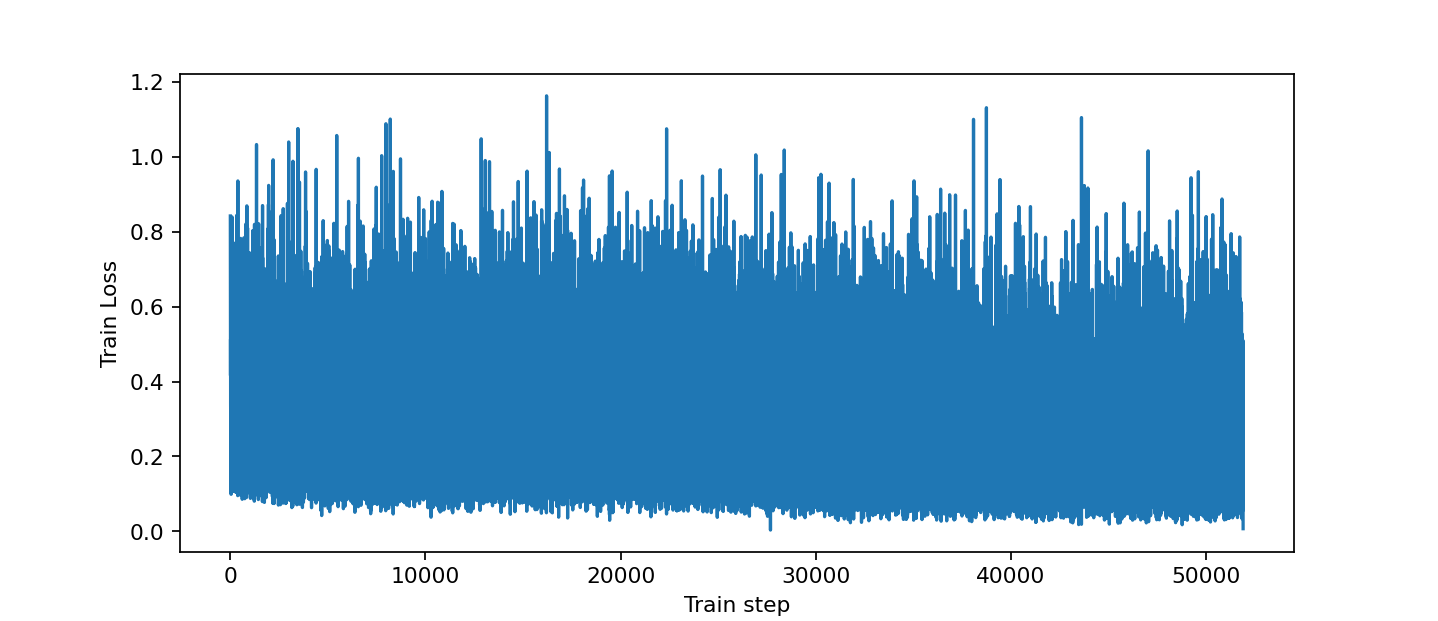

In [72]:
plt.plot(clf.all_losses)
plt.xlabel('Train step')
plt.ylabel('Train Loss')

plt.show()

<IPython.core.display.Javascript object>


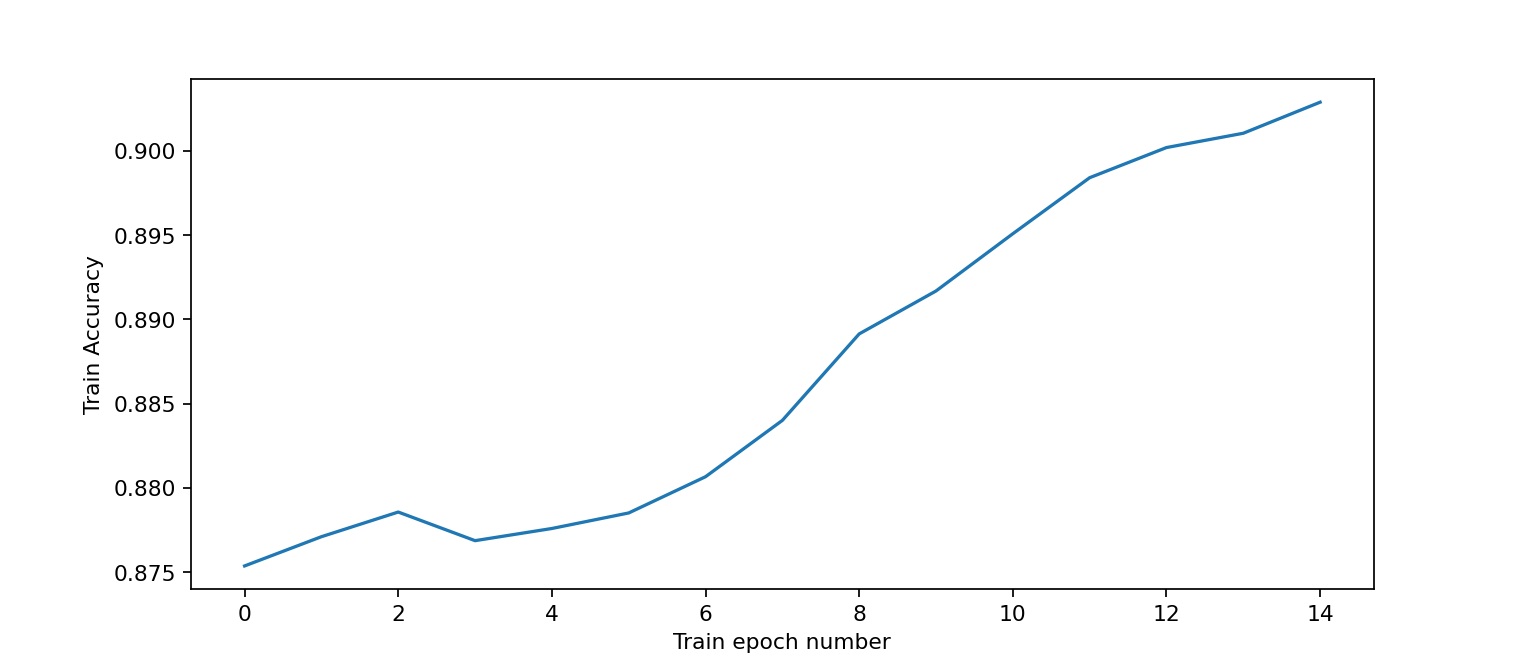

In [73]:
clf.epoch_acc = list(map(lambda t: t.cpu(), clf.epoch_acc))

plt.plot(clf.epoch_acc)
plt.xlabel('Train epoch number')
plt.ylabel('Train Accuracy')

plt.show()

<IPython.core.display.Javascript object>


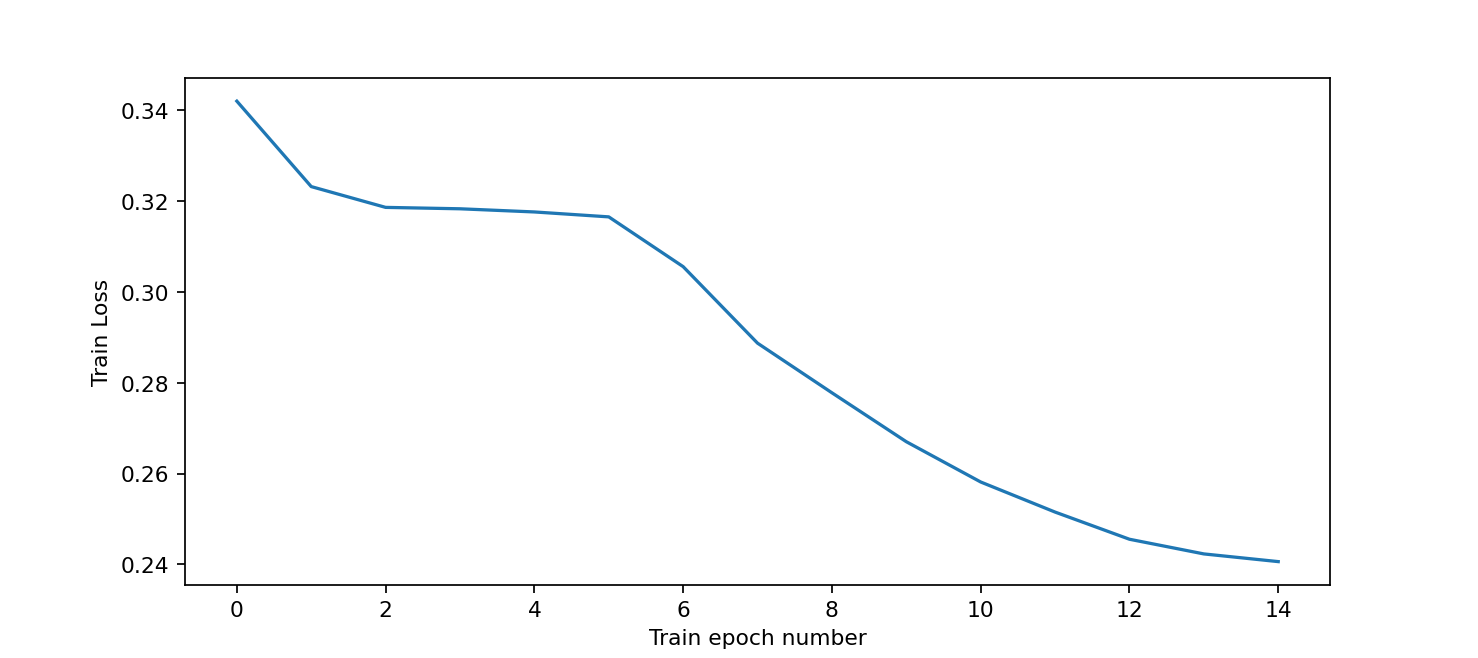

In [74]:
plt.plot(clf.epoch_losses)
plt.xlabel('Train epoch number')
plt.ylabel('Train Loss')

plt.show()